
# Учебный блокнот: эмбеддинги для русского языка — Word2Vec, Paragraph2Vec (Doc2Vec) и визуализация

**Цель:** пошагово освоить базовые операции с эмбеддингами слов и документов на русскоязычном корпусе:
обучение моделей, получение ближайших соседей, аналогии, усреднение предложений, представление документов,
поиск похожих элементов и визуализация.

## Основные определения

- **Векторное представление (эмбеддинг)** — числовой вектор фиксированной длины, отображающий объект
  (слово, предложение, документ) в непрерывное пространство признаков.
- **Word2Vec** — набор архитектур для обучения эмбеддингов слов на основе задачи предсказания контекста.
  - **CBOW**: предсказывает центральное слово по его окружению.
  - **Skip-gram**: предсказывает окружение по центральному слову (лучше для редких слов).
- **Paragraph2Vec (Doc2Vec)** — расширение идеи Word2Vec для предложений/абзацев/документов.
  - **DM (Distributed Memory)**: документ как дополнительный токен контекста.
  - **DBOW (Distributed Bag of Words)**: документ предсказывает слова.
- **Окно контекста (window)** — сколько слов слева и справа учитывается моделью.
- **Размер эмбеддинга (vector_size)** — длина вектора признаков.
- **Негативное сэмплирование (negative)** — метод ускорения обучения, упрощая softmax.
- **Семантическая близость** — косинусное сходство между векторами: чем больше, тем ближе значения.
- **Визуализация эмбеддингов** — понижение размерности (PCA, t‑SNE, UMAP) для отображения в 2D.


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 72.1 MB/s eta 0:00:00


In [ ]:

# Установка и импорт библиотек
import re
import math
import random
import pathlib
from collections import Counter # удобного интерфейса для работы с файловой системой и путями (например, Path('data/file.txt')).
# Импорт класса Counter из стандартной библиотеки collections. Он нужен для подсчета количества вхождений элементов (например, слов в тексте).
import numpy as np # Импорт библиотеки NumPy под коротким псевдонимом np.
import matplotlib.pyplot as plt # Импорт модуля pyplot из библиотеки matplotlib под псевдонимом plt. Он используется для построения графиков и визуализации данных.

import gensim # Импорт библиотеки gensim, которая используется для обработки текстов, векторизации слов (word embeddings) и моделирования смысловых представлений.
from gensim.models import Word2Vec, Doc2Vec #Word2Vec — модель для обучения векторных представлений слов;

# Doc2Vec — аналогичная модель, но для векторизации целых документов.
from gensim.models.doc2vec import TaggedDocument

from sklearn.decomposition import PCA # Импорт класса PCA (Principal Component Analysis) из scikit-learn. Он используется для снижения размерности данных, чтобы визуализировать многомерные вектора (например, вектора слов).
from sklearn.manifold import TSNE # Импорт класса TSNE (t-distributed Stochastic Neighbor Embedding) — метода нелинейного снижения размерности, часто применяемого для двухмерной визуализации высокоразмерных данных, например Word2Vec-векторов.



## Данные

По умолчанию используется небольшой русскоязычный корпус, чтобы код был воспроизводим «из коробки».
Если у вас есть папка с `.txt` файлами на русском, укажите путь и допишите код, чтобы использовать свой корпус.

Формат токенизации: приводим к нижнему регистру, удаляем цифры и знаки препинания, оставляем русские буквы.


In [ ]:
import re
import os

# Ваш встроенный мини-корпус (на случай, если файл не найдётся)
default_corpus_sentences = [
    "Машинное обучение помогает находить закономерности в данных.",
    "Нейронные сети используются для обработки текста и изображений.",
    "Семантический поиск основан на близости векторов слов и документов.",
    "Модель word2vec строит представления слов на основе контекста.",
    "Doc2Vec позволяет получать векторы для целых документов.",
    "Русский язык богат морфологией и сложным синтаксисом.",
    "Качество эмбеддингов зависит от объёма и качества корпуса.",
    "t-SNE и PCA применяются для визуализации векторов в двух измерениях.",
    "Для редких слов лучше подходит skip-gram, а для частых — CBOW.",
    "Средний вектор слов может служить простым представлением предложения."
]

def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^а-яё\s]", " ", text)
    tokens = [t for t in text.split() if t]
    return tokens

def load_corpus_from_file(filepath="game_corpus_1500.txt"):
    """Пытается загрузить корпус из файла, если не получается — возвращает встроенный"""
    if os.path.exists(filepath):
        print(f"Найден файл {filepath}, загружаю его ({os.path.getsize(filepath)/1024:.1f} КБ)...")
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read()
        # Разбиваем на предложения по точкам/восклицаниям/вопросам
        raw_sentences = re.split(r"[.!?]\s*[\n\r]+", text)
        raw_sentences = [s.strip() for s in raw_sentences if s.strip()]
        print(f"Успешно загружено {len(raw_sentences)} предложений из файла.")
    else:
        print(f"Файл {filepath} не найден → использую встроенный мини-корпус ({len(default_corpus_sentences)} предложений).")
        raw_sentences = default_corpus_sentences[:]  # копия списка

    return raw_sentences

def build_tokenized_sentences(raw_sentences):
    """Токенизирует каждое предложение и возвращает список списков токенов"""
    tokenized = []
    for sent in raw_sentences:
        tokens = simple_tokenize(sent)
        if tokens:  # отбрасываем совсем пустые предложения
            tokenized.append(tokens)
    return tokenized

# ========================
# Основной запуск
# ========================

raw_sentences = load_corpus_from_file("game_corpus_1500.txt")

# Если нужно именно список предложений-строк:
print("\nПервые 5 предложений (как строки):")
for s in raw_sentences[:5]:
    print("  •", s)

# Если нужны уже токенизированные предложения (списки слов) — для word2vec, fastText и т.д.:
tokenized_sentences = build_tokenized_sentences(raw_sentences)

print(f"\nВсего токенизированных предложений: {len(tokenized_sentences)}")
print("Первые 3 токенизированных предложения:")
for ts in tokenized_sentences[:3]:
    print("  →", ts)

# Теперь tokenized_sentences готов к обучению моделей:
# from gensim.models import Word2Vec
# model = Word2Vec(sentences=tokenized_sentences, vector_size=150, window=5, min_count=2, workers=4, sg=1)

Найден файл game_corpus_1500.txt, загружаю его (9584.0 КБ)...
Успешно загружено 45 предложений из файла.

Первые 5 предложений (как строки):
  • ================================================================================
ДОКУМЕНТ 1 | Наука
Заголовок: В Китае построили первый завод по сборке и повторному использованию ракет
Автор: Naked-science
Дата: 2025-10-11
Токенов: 838
URL: https://naked-science.ru/community/1121387
--------------------------------------------------------------------------------
пост добавить читатель naked science раздел сообщество узнать это сделать ссылка посёлок дунцзяо город вэньчан завершить строительство первый очередь завод сборка комплексный испытание повторный использование ракета носитель компания interstellar glory это первый китай комплексный завод специализироваться сборка тестирование повторный использование ракета ключевой шаг путь превращение хайнань космодром полноценный центр космический производство общий площадь застройка квадратный метр з


## Задание 1. Предобработка и токенизация (простая)

**Постановка задачи.**  
1) Преобразуйте корпус в список токенизированных предложений.  
2) Постройте частотный словарь.  
3) Покажите 20 самых частотных слов.

**Решение ниже.**


In [ ]:

tokenized_sentences = [simple_tokenize(s) for s in raw_sentences] #Создается список tokenized_sentences, в котором каждое предложение из raw_sentences преобразуется в список токенов (слов) с помощью функции simple_tokenize.
#В результате получается список списков: каждый элемент — это токенизированное предложение.
word_counts = Counter([w for sent in tokenized_sentences for w in sent])
#Создается объект Counter, который подсчитывает количество вхождений каждого слова во всем корпусе.
#Здесь используется вложенный генератор списка: он проходит по каждому предложению (for sent in tokenized_sentences), а затем по каждому слову в этом предложении (for w in sent).
print("Количество предложений:", len(tokenized_sentences))
print("Пример токенов первого предложения:", tokenized_sentences[0][:10])
print("\nТоп-20 слов:")
for w, c in word_counts.most_common(20):
    print(w, c)


Количество предложений: 45
Пример токенов первого предложения: ['документ', 'наука', 'заголовок', 'в', 'китае', 'построили', 'первый', 'завод', 'по', 'сборке']

Топ-20 слов:
год 4716
который 4031
это 3418
новый 2122
автор 1981
время 1848
документ 1843
свой 1773
система 1738
дата 1637
россия 1632
жизнь 1589
компания 1569
первый 1534
заголовок 1520
токенов 1500
работа 1490
один 1411
человек 1376
распад 1369



## Задание 2. Обучение Word2Vec (CBOW и Skip-gram)

**Постановка задачи.**  
1) Обучите две модели Word2Vec на одном корпусе: CBOW (`sg=0`) и Skip-gram (`sg=1`).  
2) Сравните ближайших соседей для нескольких слов (например: `язык`, `модель`, `поиск`).

**Решение ниже.**


In [ ]:

# Параметры подобраны для быстроты;
w2v_params = dict(vector_size=100, window=5, min_count=1, workers=1, epochs=50, seed=42)

model_cbow = Word2Vec(sentences=tokenized_sentences, sg=0, **w2v_params)
model_sg   = Word2Vec(sentences=tokenized_sentences, sg=1, **w2v_params)

test_words = ["язык", "модель", "поиск"]
for w in test_words:
    if w in model_cbow.wv:
        print("\nCBOW ближайшие слова к:", w)
        for n, score in model_cbow.wv.most_similar(w, topn=5):
            print(n, round(float(score), 3))
    else:
        print("\nСлова нет в словаре CBOW:", w)

    if w in model_sg.wv:
        print("Skip-gram ближайшие слова к:", w)
        for n, score in model_sg.wv.most_similar(w, topn=5):
            print(n, round(float(score), 3))
    else:
        print("Слова нет в словаре Skip-gram:", w)



CBOW ближайшие слова к: язык
идиш 0.645
русский 0.611
английский 0.577
хроник 0.514
сдавать 0.49
Skip-gram ближайшие слова к: язык
русский 0.788
великодержавный 0.666
шовинизм 0.649
южность 0.649
каббал 0.626

CBOW ближайшие слова к: модель
кроссовер 0.561
линейка 0.549
автомобиль 0.526
флагманский 0.524
ноутбук 0.515
Skip-gram ближайшие слова к: модель
недешёвый 0.717
половинка 0.669
вычленить 0.662
среднебюджетный 0.66
переоткрытие 0.657

CBOW ближайшие слова к: поиск
внеземной 0.691
бозона 0.621
хиггсовского 0.611
нейро 0.591
локерби 0.581
Skip-gram ближайшие слова к: поиск
констатировать 0.711
браконьер 0.686
утилита 0.679
коммунизм 0.679
суперсимметрия 0.678



## Задание 3. Аналогии на эмбеддингах слов

**Постановка задачи.**  
Реализуйте простую аналогию вида `a - b + c ≈ ?`.  
Пример: `обучение` − `данные` + `модель` → найдите ближайшее слово.

**Решение ниже.**


In [ ]:

def analogy(model, a, b, c, topn=5):
    for w in (a, b, c):
        if w not in model.wv:
            return f"Слова '{w}' нет в словаре."
    result = model.wv.most_similar(positive=[a, c], negative=[b], topn=topn)
    return [(w, float(s)) for w, s in result]

print("CBOW:", analogy(model_cbow, "обучение", "данные", "модель"))
print("Skip-gram:", analogy(model_sg, "обучение", "данные", "модель"))


CBOW: [('ноутбук', 0.5184036493301392), ('преимущественно', 0.4865474998950958), ('флагманский', 0.46985915303230286), ('зависимость', 0.4544605016708374), ('смартфон', 0.44911065697669983)]
Skip-gram: [('весы', 0.4924112856388092), ('среднебюджетный', 0.478390634059906), ('сие', 0.4712412357330322), ('вычленить', 0.4710274636745453), ('флагманский', 0.4708766043186188)]



## Задание 4. Визуализация слов (PCA и t‑SNE)

**Постановка задачи.**  
1) Сформируйте список слов (не менее 20).  
2) Постройте двумерные проекции эмбеддингов с помощью PCA и t‑SNE.  
3) Подпишите точки словами.

**Решение ниже.**


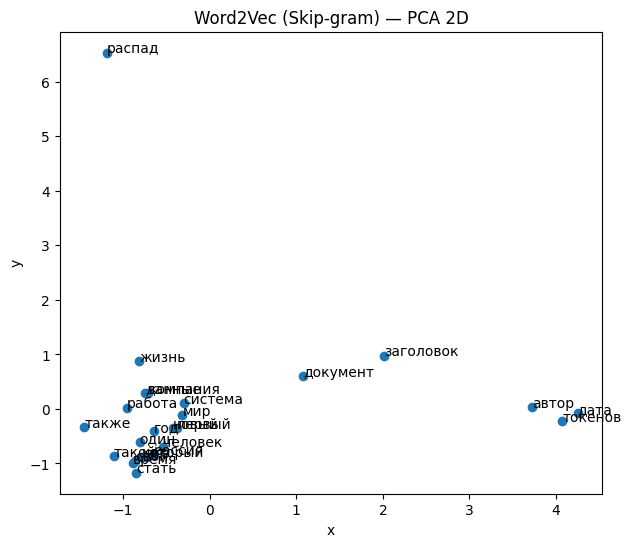

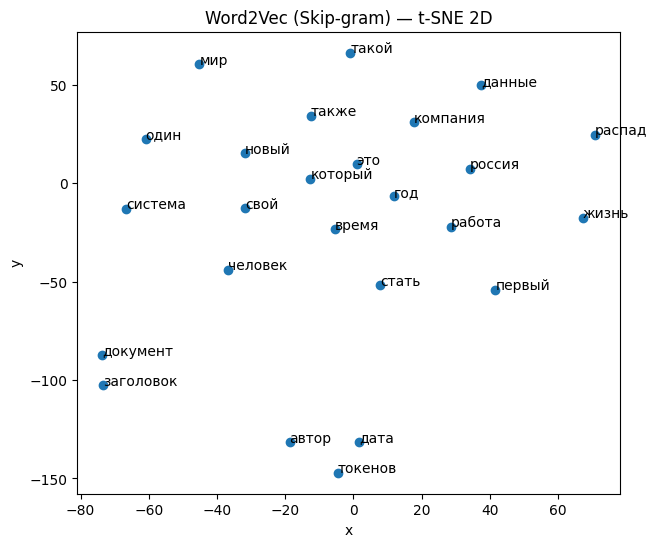

In [ ]:

def plot_2d(points, labels, title):
    x = points[:, 0]
    y = points[:, 1]
    plt.figure(figsize=(7, 6))
    plt.scatter(x, y)
    for i, lab in enumerate(labels):
        plt.annotate(lab, (x[i], y[i]))
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Выберем слова по частоте
vocab_sorted = [w for w, _ in word_counts.most_common(30) if w in model_sg.wv]
words = vocab_sorted[:25] if len(vocab_sorted) >= 25 else vocab_sorted
X = np.array([model_sg.wv[w] for w in words])

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
plot_2d(X_pca, words, "Word2Vec (Skip-gram) — PCA 2D")

# t-SNE
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=min(10, max(5, len(words)//3)), random_state=42)
X_tsne = tsne.fit_transform(X)
plot_2d(X_tsne, words, "Word2Vec (Skip-gram) — t-SNE 2D")



## Задание 5. Эмбеддинги предложений простым средним

**Постановка задачи.**  
1) Получите вектор для каждого предложения как среднее эмбеддингов его слов (пропускайте слова вне словаря).  
2) Найдите ближайшие к выбранному предложению по косинусному сходству.  
3) Визуализируйте 2D‑проекцию предложений и подпишите краткими метками.

**Решение ниже.**


Запрос: ================================================================================
ДОКУМЕНТ 1 | Наука
Заголовок: В Китае построили первый завод по сборке и повторному использованию ракет
Автор: Naked-science
Дата: 2025-10-11
Токенов: 838
URL: https://naked-science.ru/community/1121387
--------------------------------------------------------------------------------
пост добавить читатель naked science раздел сообщество узнать это сделать ссылка посёлок дунцзяо город вэньчан завершить строительство первый очередь завод сборка комплексный испытание повторный использование ракета носитель компания interstellar glory это первый китай комплексный завод специализироваться сборка тестирование повторный использование ракета ключевой шаг путь превращение хайнань космодром полноценный центр космический производство общий площадь застройка квадратный метр завод реализовать инновационный трехкомпонентный модель сборка испытание повторный использование создавать единый замкнутый цикл производс

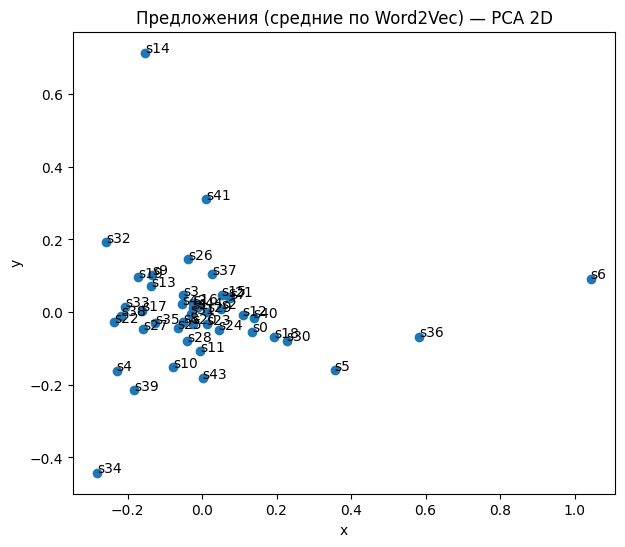

In [ ]:

def sent_vector_avg(model, tokens):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if not vecs:
        return np.zeros(model.vector_size, dtype=float)
    return np.mean(vecs, axis=0)

sent_vectors = np.vstack([sent_vector_avg(model_sg, sent) for sent in tokenized_sentences])

def cosine_sim(a, b):
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))

query_id = 0  # можно менять индекс
scores = []
for i, v in enumerate(sent_vectors):
    if i == query_id:
        continue
    scores.append((i, cosine_sim(sent_vectors[query_id], v)))

scores.sort(key=lambda x: x[1], reverse=True)
print("Запрос:", raw_sentences[query_id])
print("\nТоп-5 похожих предложений:")
for i, s in scores[:5]:
    print(round(s, 3), raw_sentences[i])

# Визуализация предложений (PCA)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(sent_vectors)

labels = [f"s{i}" for i in range(len(raw_sentences))]
plot_2d(X_pca, labels, "Предложения (средние по Word2Vec) — PCA 2D")



## Задание 6. Paragraph2Vec / Doc2Vec (DM и DBOW)

**Постановка задачи.**  
1) Подготовьте данные как `TaggedDocument`, где каждый документ — одно предложение `s{i}`.  
2) Обучите две модели Doc2Vec: `dm=1` (DM) и `dm=0` (DBOW).  
3) Сравните ближайшие документы для выбранного индекса.  
4) Сравните с методом среднего по Word2Vec (из предыдущего задания).

**Решение ниже.**


In [ ]:

tagged = [TaggedDocument(words=sent, tags=[f"s{i}"]) for i, sent in enumerate(tokenized_sentences)]

d2v_params = dict(vector_size=100, window=5, min_count=1, workers=1, epochs=60, seed=42, negative=5)
doc2vec_dm   = Doc2Vec(documents=tagged, dm=1, **d2v_params)
doc2vec_dbow = Doc2Vec(documents=tagged, dm=0, **d2v_params)

def top_similar_docs(model, idx, topn=5):
    tag = f"s{idx}"
    sims = model.dv.most_similar(tag, topn=topn+1)
    sims = [(t, float(s)) for t, s in sims if t != tag]
    return sims[:topn]

query_idx = 0  # можно менять
print("Запрос:", f"s{query_idx}:", raw_sentences[query_idx])

print("\nDoc2Vec DM — похожие:")
for t, s in top_similar_docs(doc2vec_dm, query_idx, topn=5):
    print(s, t, ":", raw_sentences[int(t[1:])])

print("\nDoc2Vec DBOW — похожие:")
for t, s in top_similar_docs(doc2vec_dbow, query_idx, topn=5):
    print(s, t, ":", raw_sentences[int(t[1:])])

print("\nСравнение с усреднёнными Word2Vec (из задания 5):")
for i, s in scores[:5]:
    print(s, f"s{i}", ":", raw_sentences[i])


Запрос: s0: Машинное обучение помогает находить закономерности в данных.

Doc2Vec DM — похожие:
0.1384369134902954 s2 : Семантический поиск основан на близости векторов слов и документов.
0.11570832878351212 s8 : Для редких слов лучше подходит skip-gram, а для частых — CBOW.
0.07440976798534393 s5 : Русский язык богат морфологией и сложным синтаксисом.
0.07169314473867416 s3 : Модель word2vec строит представления слов на основе контекста.
0.023889973759651184 s7 : t-SNE и PCA применяются для визуализации векторов в двух измерениях.

Doc2Vec DBOW — похожие:
0.28884512186050415 s2 : Семантический поиск основан на близости векторов слов и документов.
0.23714475333690643 s8 : Для редких слов лучше подходит skip-gram, а для частых — CBOW.
0.17773129045963287 s9 : Средний вектор слов может служить простым представлением предложения.
0.1666315793991089 s7 : t-SNE и PCA применяются для визуализации векторов в двух измерениях.
0.16590748727321625 s5 : Русский язык богат морфологией и сложным си


## Задание 7. Инференс вектора для нового текста

**Постановка задачи.**  
1) Возьмите произвольное новое русское предложение (не из обучающего набора).  
2) Получите его вектор методом `infer_vector`.  
3) Найдите ближайшие документы из корпуса и выведите их тексты.

**Решение ниже.**


In [ ]:

new_text = "Эмбеддинги помогают сравнивать смысл предложений и документов."
new_tokens = simple_tokenize(new_text)
vec_inferred = doc2vec_dm.infer_vector(new_tokens, epochs=50)
sims = doc2vec_dm.dv.most_similar([vec_inferred], topn=5)

print("Новый текст:", new_text)
print("\nПохожие документы:")
for tag, sim in sims:
    i = int(tag[1:])
    print(round(float(sim), 3), tag, ":", raw_sentences[i])


Новый текст: Эмбеддинги помогают сравнивать смысл предложений и документов.

Похожие документы:
0.231 s3 : Модель word2vec строит представления слов на основе контекста.
0.13 s2 : Семантический поиск основан на близости векторов слов и документов.
0.065 s5 : Русский язык богат морфологией и сложным синтаксисом.
0.062 s0 : Машинное обучение помогает находить закономерности в данных.
0.03 s7 : t-SNE и PCA применяются для визуализации векторов в двух измерениях.



## Задание 8. Визуализация документов (Doc2Vec)

**Постановка задачи.**  
1) Получите матрицу векторов документов из `doc2vec_dm`.  
2) Постройте 2D‑проекцию (PCA или t‑SNE).  
3) Подпишите точки идентификаторами `s{i}`.

**Решение ниже.**


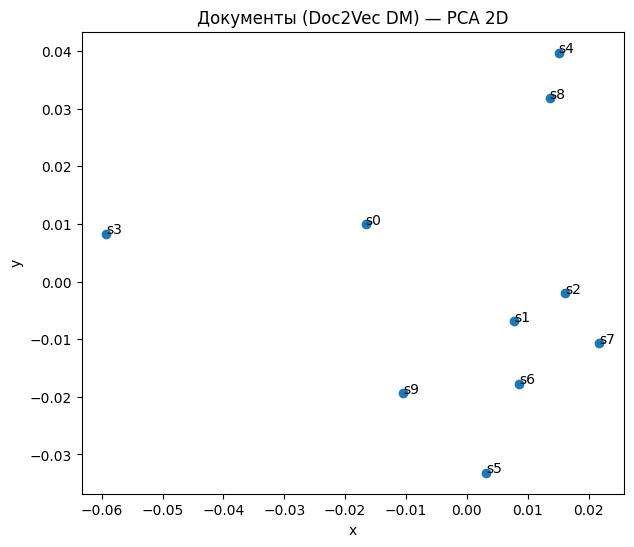

In [ ]:

doc_vectors = np.vstack([doc2vec_dm.dv[f"s{i}"] for i in range(len(tokenized_sentences))])
pca = PCA(n_components=2, random_state=42)
X_pca_docs = pca.fit_transform(doc_vectors)
labels_docs = [f"s{i}" for i in range(len(tokenized_sentences))]
plot_2d(X_pca_docs, labels_docs, "Документы (Doc2Vec DM) — PCA 2D")



## Задание 9. Влияние гиперпараметров

**Постановка задачи.**  
1) Сравните близости между парами слов при разных `vector_size` и `window`.  
2) Выведите таблицу косинусных сходств для набора пар слов и обсудите устойчивость результатов.

**Решение ниже.**


In [ ]:

pairs = [("модель", "поиск"), ("язык", "морфологией"), ("векторов", "эмбеддингов")]
configs = [
    dict(vector_size=50, window=3, sg=1),
    dict(vector_size=100, window=5, sg=1),
]

def train_quick(params):
    p = dict(vector_size=params["vector_size"], window=params["window"],
             min_count=1, workers=1, epochs=40, seed=42)
    m = Word2Vec(sentences=tokenized_sentences, sg=params["sg"], **p)
    return m

results = []
for cfg in configs:
    m = train_quick(cfg)
    row = {"vector_size": cfg["vector_size"], "window": cfg["window"], "sg": cfg["sg"]}
    for a, b in pairs:
        if a in m.wv and b in m.wv:
            sim = np.dot(m.wv[a], m.wv[b]) / (np.linalg.norm(m.wv[a]) * np.linalg.norm(m.wv[b]))
            row[f"{a}-{b}"] = float(sim)
        else:
            row[f"{a}-{b}"] = None
    results.append(row)

import pandas as pd
df = pd.DataFrame(results)
df


vector_size  window  sg  модель-поиск  язык-морфологией  \
0           50       3   1      0.000031          0.032085   
1          100       5   1     -0.112428          0.080455   

   векторов-эмбеддингов  
0             -0.040759  
1             -0.140197


## Задание 10. Простой семантический поиск по предложениям

**Постановка задачи.**  
1) Реализуйте поиск по запросу: получить вектор запроса как среднее по словам.  
2) Отсортируйте предложения корпуса по косинусному сходству с запросом.  
3) Выведите топ‑результаты.

**Решение ниже.**


In [ ]:

def search_simple(query, model, k=5):
    q_tokens = simple_tokenize(query)
    q_vec = sent_vector_avg(model, q_tokens)
    scored = []
    for i, v in enumerate(sent_vectors):
        scored.append((i, cosine_sim(q_vec, v)))
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored[:k]

query = "визуализация векторов слов"
hits = search_simple(query, model_sg, k=5)
print("Запрос:", query)
print("\nТоп-результаты:")
for i, s in hits:
    print(round(s, 3), f"s{i}:", raw_sentences[i])


Запрос: визуализация векторов слов

Топ-результаты:
0.55 s2: Семантический поиск основан на близости векторов слов и документов.
0.369 s7: t-SNE и PCA применяются для визуализации векторов в двух измерениях.
0.343 s8: Для редких слов лучше подходит skip-gram, а для частых — CBOW.
0.277 s3: Модель word2vec строит представления слов на основе контекста.
0.165 s9: Средний вектор слов может служить простым представлением предложения.



## Что дальше

- Замените упрощённую токенизацию на стемминг/лемматизацию (например, pymorphy2) и сравните результаты.
- Увеличьте корпус, переобучите модели и сравните качество по ближайшим соседям и поиску.
- Добавьте сохранение и загрузку моделей (`save`/`load`) для последующего использования.


In [ ]:
def advanced_tokenize(text):
    """Улучшенная токенизация с лемматизацией"""
    try:
        import pymorphy2
        from nltk.tokenize import word_tokenize
    except ImportError:
        print("Для продвинутой нужен pip install pymorphy2 nltk")
        return [simple_tokenize(text)]

    # Инициализация только при первом вызове
    if not hasattr(advanced_tokenize, 'morph'):
        advanced_tokenize.morph = pymorphy2.MorphAnalyzer()

    # Разбиваем на предложения (простой способ)
    sentences = re.split(r'[.!?]+', text)

    all_sentences_tokens = []

    for sent in sentences:
        sent = sent.strip()
        if not sent:
            continue

        # Токенизация
        words = word_tokenize(sent, language='russian')

        # Лемматизация и фильтрация
        tokens = []
        for word in words:
            word_lower = word.lower()
            # Оставляем только русские слова
            if re.match(r'^[а-яё]+$', word_lower):
                try:
                    lemma = advanced_tokenize.morph.parse(word_lower)[0].normal_form
                    tokens.append(lemma)
                except:
                    tokens.append(word_lower)

        if tokens:
            all_sentences_tokens.append(tokens)

    return all_sentences_tokens

# Тестируем улучшенную токенизацию
test_text = "Машинное обучение помогает находить закономерности в данных. Нейронные сети используются для обработки текста."
print("Простая токенизация:", simple_tokenize(test_text))
print("Продвинутая токенизация:", advanced_tokenize(test_text))

Простая токенизация: ['машинное', 'обучение', 'помогает', 'находить', 'закономерности', 'в', 'данных', 'нейронные', 'сети', 'используются', 'для', 'обработки', 'текста']
Для продвинутой токенизации установите: pip install pymorphy2 nltk
Продвинутая токенизация: [['машинное', 'обучение', 'помогает', 'находить', 'закономерности', 'в', 'данных', 'нейронные', 'сети', 'используются', 'для', 'обработки', 'текста']]
